# Description
## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

## Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

Author: Alishan Premani

Date: 12/13/2022

# Load Packages

In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist, cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
 
# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# Load Data

In [234]:
df = pd.read_csv('Credit_Card_Customer_Data.csv')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


Data looks OK - let's dive deeper. 

# Basic Analysis

Let's start by dropping Sl_No and Customer Key columns since we will not be needing them.

In [235]:
df.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

In [236]:
print(df.head())
print(df.shape)

   Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3  
(660, 5)


This dataset has 660 data points and 5 columns.

In [237]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


Observations:
- The mean credit limit of customers at AllLife Bank is \$34.5k, with a high standard deviation. Even though more than 75% of the customers' credit limits are within \$48k, the maximum limit goes up to \$200k, and is probably worth looking into. The minimum credit limit is \$3k, which means that all values in this column are non-zero. 
- The average customer has around 4.7 credit cards and 75% of them have more than 3 cards. The maximum is 10, and perhaps the outliers are worth checking.
- A customer averages about 2.4 annual visits to the bank with at least 75% making at least one annual visit.
- Online visit are slightly higher than in person visits, averaging about 2.6 per year, but with a higher standard deviation of 2.9 visits, the maximum being 15. We can check some outliers in this column.
- Total calls made average about 3.5 per year, with 75% customers making at most 5 calls.

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [239]:
# let's look at unique values for all discrete valued columns
num_cols = list(df.columns)
for col in num_cols:
    if col not in ['Avg_Credit_Limit']:
        print(f"Value counts for {col}:")
        print(df[col].value_counts())

Value counts for Total_Credit_Cards:
4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64
Value counts for Total_visits_bank:
2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64
Value counts for Total_visits_online:
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
10      6
12      6
8       6
11      5
13      5
9       4
14      1
6       1
Name: Total_visits_online, dtype: int64
Value counts for Total_calls_made:
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64


In [240]:
df.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

All columns are numerical, and have non-negative and non null values. Let's check for duplicate data points.

In [241]:
df.duplicated().sum()

11

We have 11 duplicate data points. Let's remove them.

In [242]:
df.drop_duplicates(keep='first', inplace = True)
df.shape

(649, 5)

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     649 non-null    int64
 1   Total_Credit_Cards   649 non-null    int64
 2   Total_visits_bank    649 non-null    int64
 3   Total_visits_online  649 non-null    int64
 4   Total_calls_made     649 non-null    int64
dtypes: int64(5)
memory usage: 30.4 KB


Let's transition to Exploratory Data Analysis.

# Exploratory Data Analysis (EDA)

In [244]:
# function to create custom labeled barplot
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

## Univariate Analysis

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Count'>

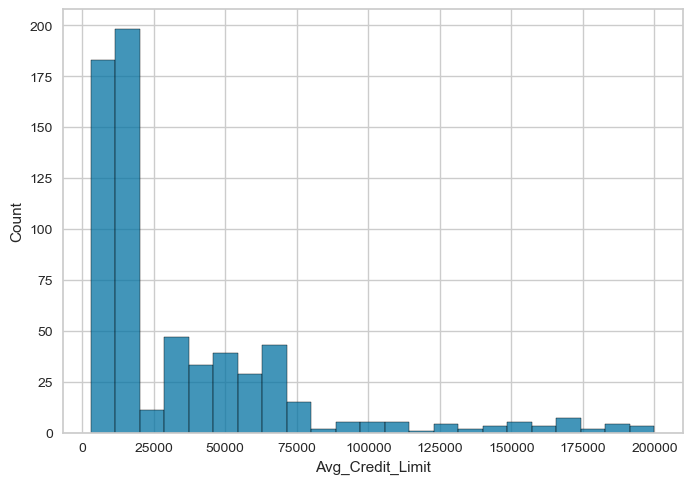

In [245]:
sns.histplot(data=df, x='Avg_Credit_Limit')

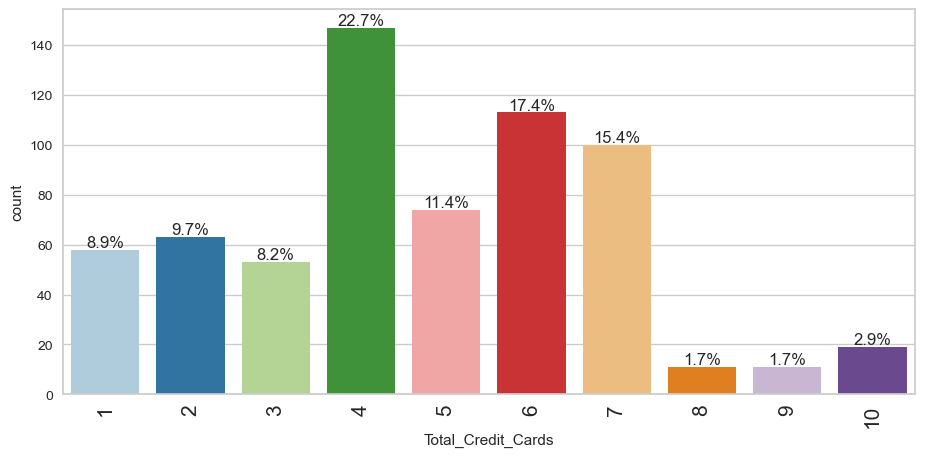

In [246]:
labeled_barplot(df, 'Total_Credit_Cards', perc=True)

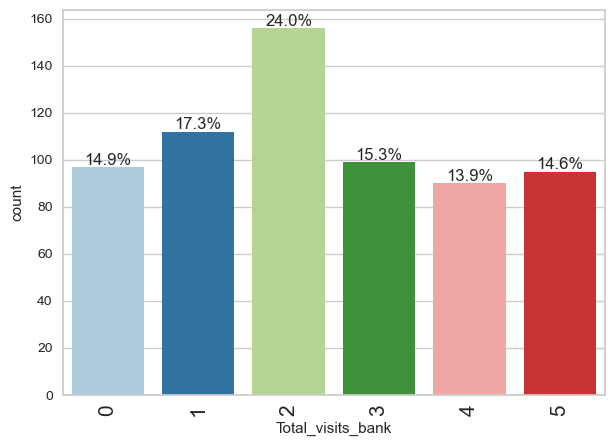

In [247]:
labeled_barplot(df, 'Total_visits_bank', perc=True)

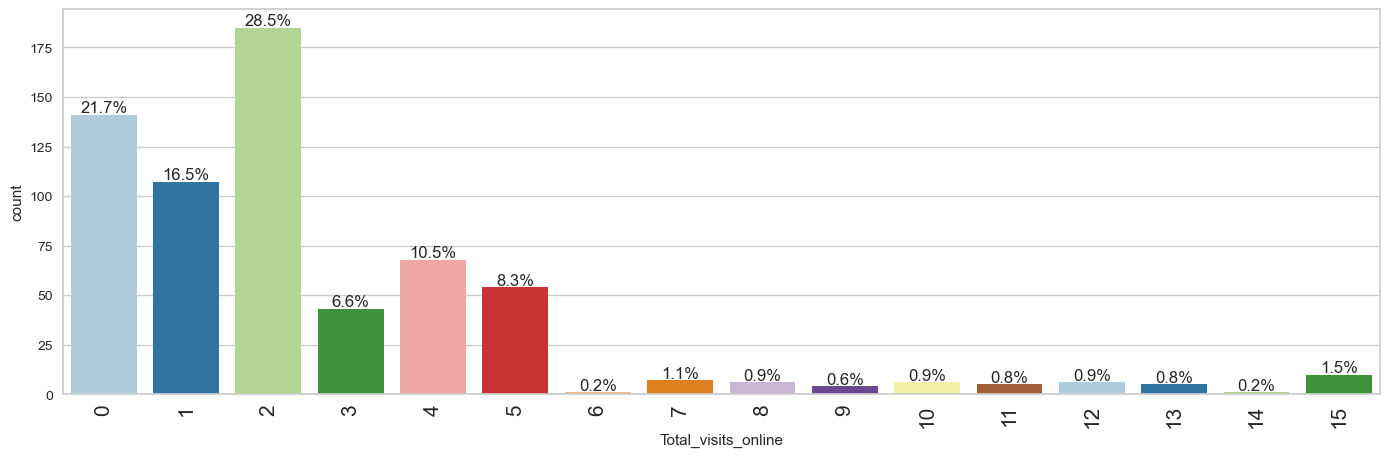

In [248]:
labeled_barplot(df, 'Total_visits_online', perc=True)

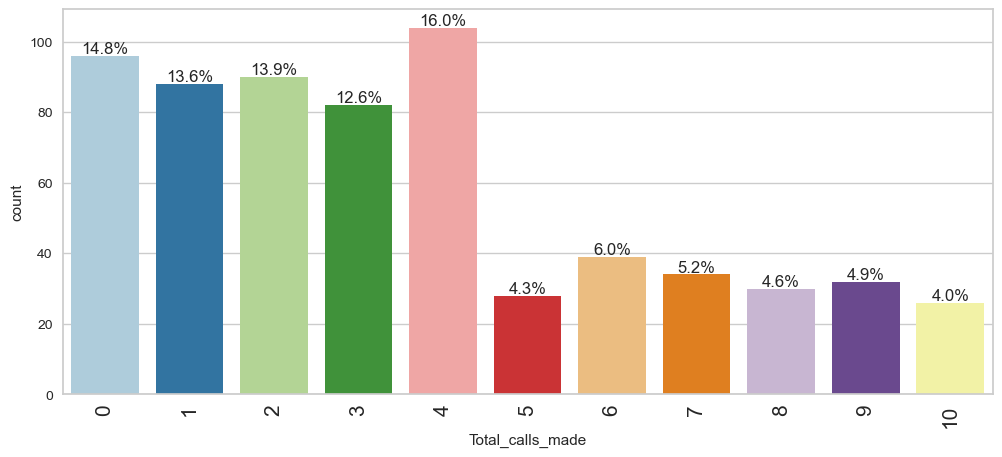

In [249]:
labeled_barplot(df, 'Total_calls_made', perc=True)

Observations:

- Average credit limit is extremely right skewed, most customers' credit limit is less than \$25k.
- Most customers have between 4 to 7 credit cards.
- 2 visits to the bank are the most common, and about an equal proportion of customers visited the bank between 0 and 5 times (except for 2).
- Most customers made online visits up to 5 times annually and made calls to the bank up to 4 times.

Overall, the data set seems well-balanced. It would be more beneficial to have more customers with a higher credit limit and number of credit cards, if possible.

### Outlier Detection and Treatment

All columns' extreme values are reasonable except for average credit limit - outlier values for this column go up to \$200k. Let's take a look at some of these data points.

In [250]:
df[df['Avg_Credit_Limit']>175000]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
622,176000,10,1,15,2
624,178000,7,0,11,0
630,200000,10,0,13,0
631,195000,8,0,15,0
632,187000,7,1,7,0
639,184000,7,1,15,2
646,186000,7,0,8,1
647,183000,9,0,9,2
650,195000,10,1,12,2


All the above values seems reasonable, so we will move on.

## Bivariate Analysis

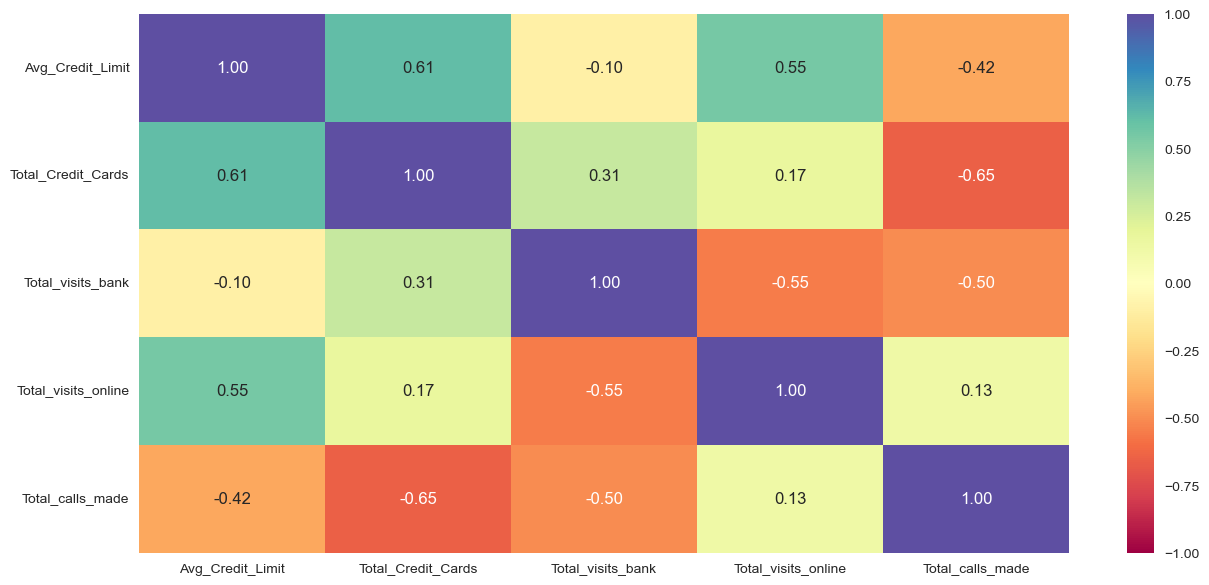

In [251]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    df[list(df.columns)].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

Observations:

- Average credit limit has a high positive correlation with total credit cards, which make sense. The more cards you own, the more your limit adds up.
- Average credit limit is also highly correlated with total online visits. Depending on the reason for online visits, this is reasonable. For example, to pay your monthly bill, or look up FAQs or check your balance. The more cards a customer has, the more a customer would visit online to do those things.
- Average credit limit, total credit cards and total in person visits to the bank are all negatively correlated with total calls made. The reasons for this can be two-fold. First, the more financial services a customer are using, the more satisfied with and knowledgeable about the bank and its services the customer might tend to be, and hence the less communication they would require. Second, if a customer has satisfactorily made more online visits to the bank, their queries have been resolved, and hence the need to visit the bank or call them has diminished. This also alludes to the high quality and query-resolving ability of the bank's online visiting platform. This might also work in a vice versa manner - perhaps customers that visit or call the bank may not know about or have much confidence in online visits.
- Interestingly, total online visits has a negative correlation with in person visits, but has little to no correlation with calls made to the bank. This means that customers might take either route in resolving their queries. However, we have now observed that customers that heavily use the bank's services prefer online visits.

Depending on the reality, the bank should look to improve its calling and in person issue-resolving services.

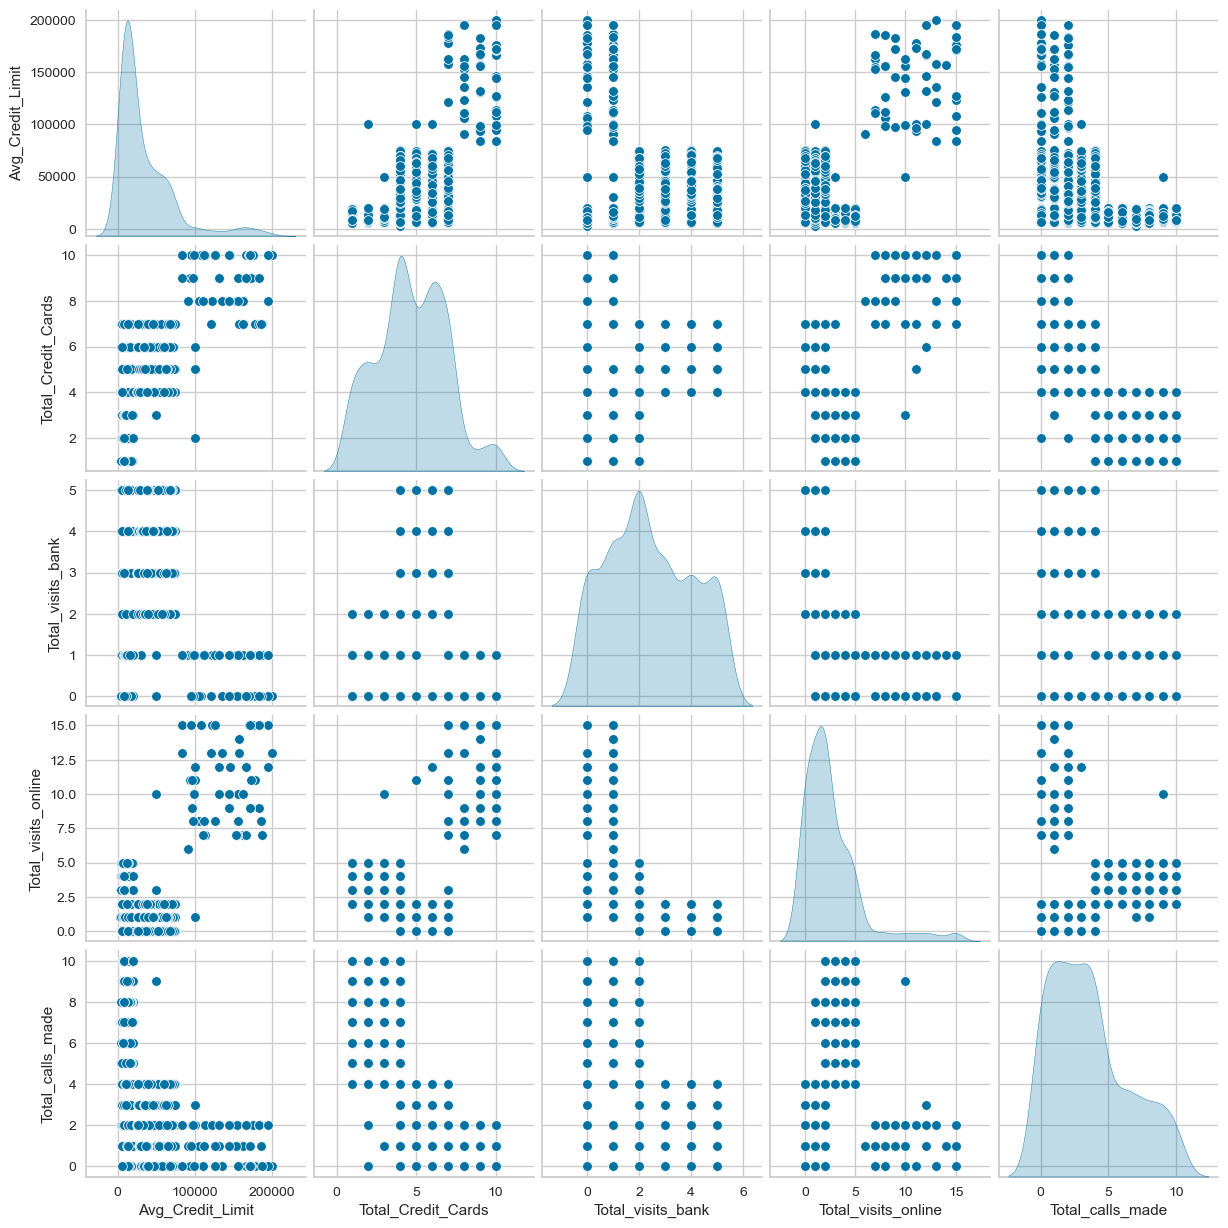

In [252]:
sns.pairplot(data=df, diag_kind='kde')

Observations

- The humps in the diagonal graphs allude to the wide range in which we would have to search to find the appropriate number of clusters for this dataset. Each graph has at least 2-3 humps.

# Clustering

Let's scale the data down to each column's zscores to start applying the Hierarchical and KMeans Clustering techniques.

In [253]:
sc = StandardScaler()
scaled_data = sc.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
df_scaled

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216
...,...,...,...,...,...
644,1.697034,2.436005,-0.860606,2.499808,-1.248443
645,1.300046,2.436005,-0.860606,3.516546,-0.552958
646,2.914461,1.515232,-0.860606,2.160895,-0.900701
647,3.629038,2.436005,-0.860606,4.194372,-1.248443


### K-Means Clustering

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9876413821975012
Number of Clusters: 6 	Average Distortion: 0.9402222308832852
Number of Clusters: 7 	Average Distortion: 0.9201856064729766
Number of Clusters: 8 	Average Distortion: 0.8875633424024478
Number of Clusters: 9 	Average Distortion: 0.8610870805111308
Number of Clusters: 10 	Average Distortion: 0.838530472659708


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

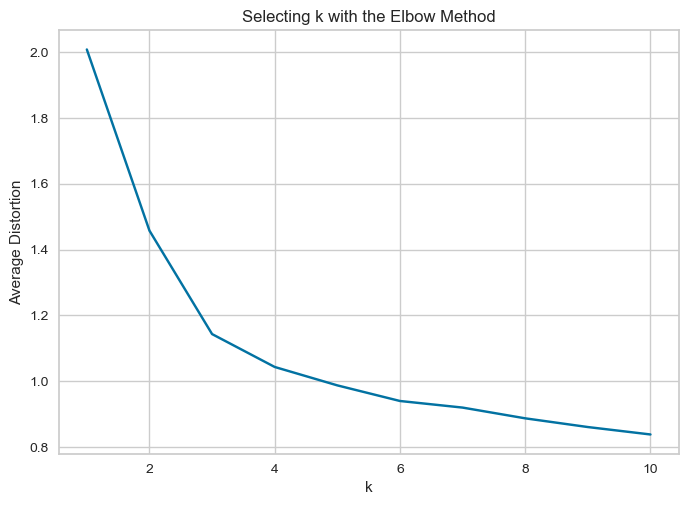

In [254]:
df_scaled_KM = df_scaled.copy()
df_KM = df.copy()

clusters = range(1, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_scaled_KM)
    prediction = model.predict(df_scaled_KM)
    distortion = (
        sum(
            np.min(cdist(df_scaled_KM, model.cluster_centers_, "euclidean"), axis=1)
        )
        / df_scaled_KM.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method")

The appropriate value of K from the elbow curve seems to be 3. Let us check the silhouette scores.

For n_clusters = 2, silhouette score is 0.41800025566689647
For n_clusters = 3, silhouette score is 0.516281010855363
For n_clusters = 4, silhouette score is 0.3570238219413198
For n_clusters = 5, silhouette score is 0.2730908848204727
For n_clusters = 6, silhouette score is 0.25719485802606895
For n_clusters = 7, silhouette score is 0.2502545988014861
For n_clusters = 8, silhouette score is 0.22732722341209033
For n_clusters = 9, silhouette score is 0.21657433518182687


Text(0, 0.5, 'Silhoutte Score')

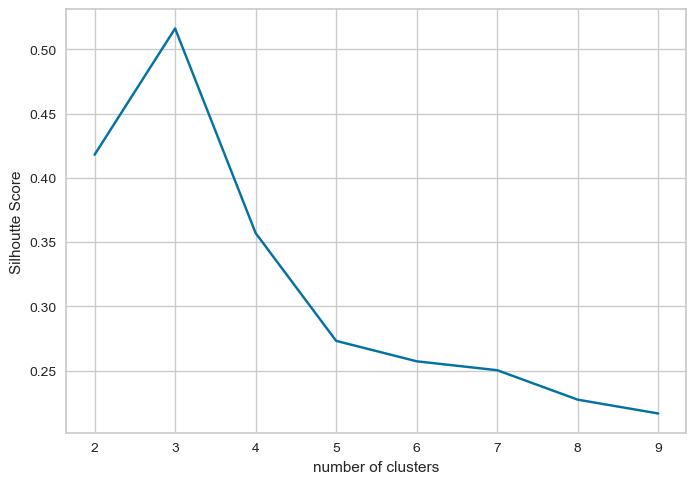

In [255]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_scaled_KM))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled_KM, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score);
plt.xlabel('number of clusters')
plt.ylabel('Silhoutte Score')

k=3 has the highest silhoutte score.

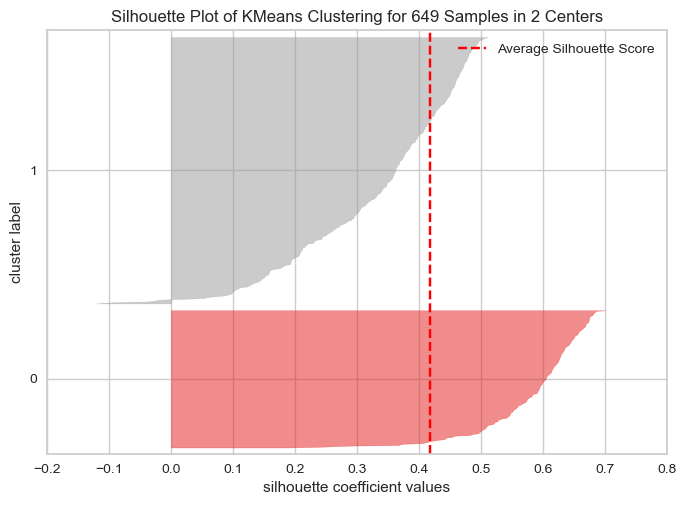

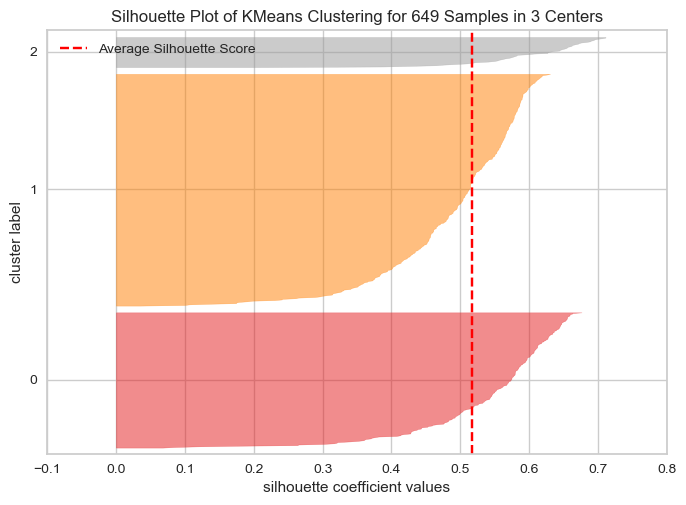

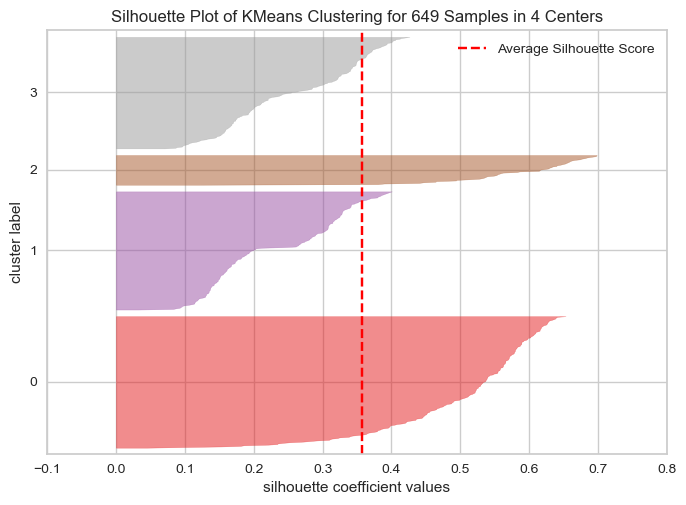

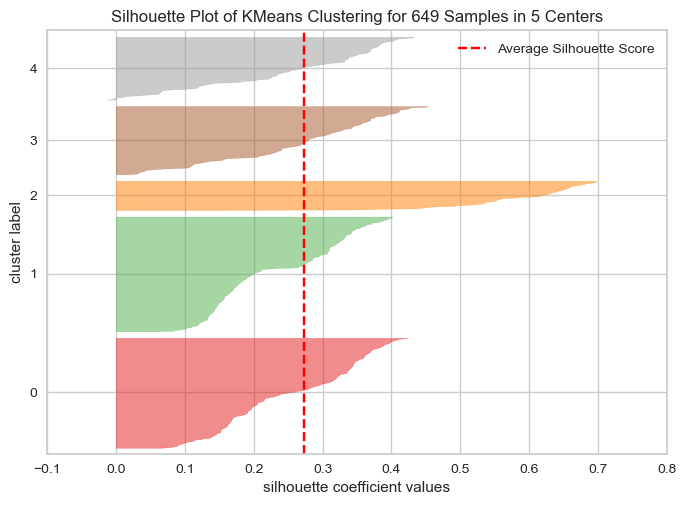

In [256]:
# finding optimal no. of clusters with silhouette coefficients
for k in range(2,6):
    visualizer = SilhouetteVisualizer(KMeans(k, random_state=1))
    visualizer.fit(df_scaled_KM)
    visualizer.show()

We shall choose k=3 as the appropriate number of clusters because the average silhoutte score is highest for k=3, and the individual silhoutte scores for each cluster is high when k=3.

In [257]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_scaled_KM)

KMeans(n_clusters=3, random_state=1)

In [258]:
# adding kmeans cluster labels to the original dataframe
df_KM["K_means_segments"], df_scaled_KM["K_means_segments"] = kmeans.labels_, kmeans.labels_

In [259]:
cluster_profile_KM = df_KM.groupby("K_means_segments").mean()
cluster_profile_scaled_KM = df_scaled_KM.groupby("K_means_segments").mean()

In [260]:
cluster_profile_KM["count_in_each_segment"] = (
    df_KM.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

cluster_profile_scaled_KM["count_in_each_segment"] = (
    df_scaled_KM.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

#### Cluster Profiling - K-Means

In [261]:
# let's display cluster profiles
cluster_profile_KM.style.highlight_max(color="green", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403,221
1,34071.428571,5.518519,3.484127,0.981481,1.992063,378
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


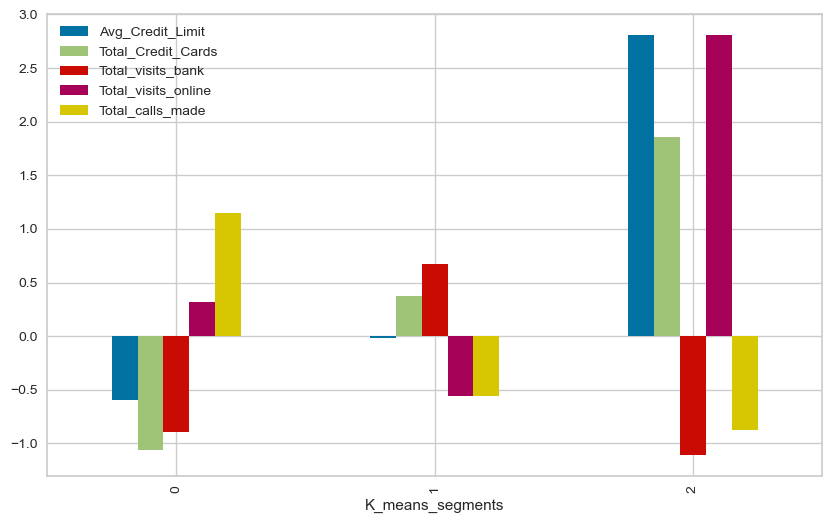

In [262]:
df_scaled_KM.groupby("K_means_segments").mean().plot.bar(figsize=(10, 6));

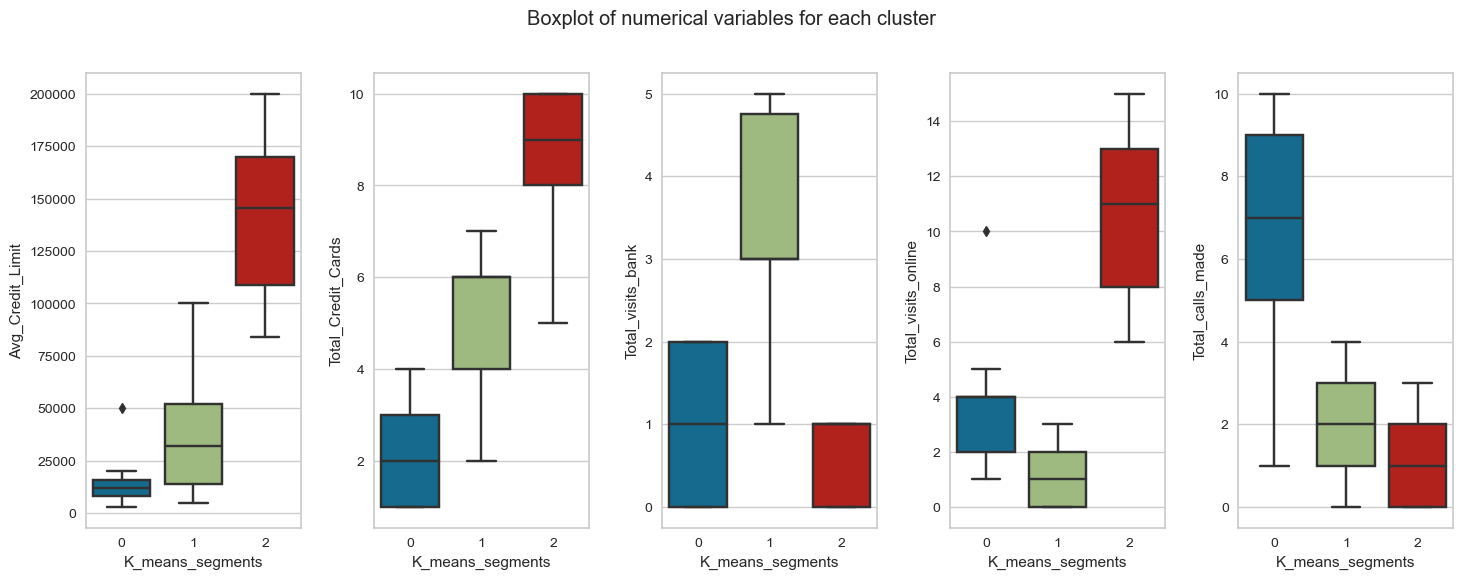

In [263]:
num_col = list(df_KM.columns)
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
for i in range(5):
    sns.boxplot(ax=axes[i], y=df[num_col[i]], x=df_KM["K_means_segments"])

fig.tight_layout(pad=1.7)

#### Insights

<b> Cluster 0 </b>
- This cluster has 224 customers.
- Customers grouped here made a high number of calls but have low credit limit and number of credit cards with the bank, as well as low online and in person visits to the bank.
- Since Cluster 0 is the only cluster with high number of phone calls, we can perhaps deduce that the customers might have been unsatisfied with the bank's services, which resulted in more calls being made.

<b> Cluster 1 </b>
- This cluster has 386 customers, which is the majority between all clusters.
- Customers here have a moderate number of credit cards but a high number of in person visits.

<b> Cluster 2 </b>
- This cluster has 50 customers.
- Customers here have a high credit limit, high number of credit cards and high online visits, but low in person visits and calls to the bank.

#### Recommendations

- A majority of the customers visit and call the bank at least once, so a recommendation would be for the bank to further improve its services in calling and in person visits so that customers are satisfied.
- To target new customers, the bank should market their services to customers from cluster 2, since they have high usage of the bank's financial services.

Data suggestions:
- Perhaps it would be more useful for the Data Scientists to have data about outcomes of all the modes of communication, as well as reason for communication. This would help in better analyzing and providing recommendations for the bank's issue-resolving services, as well as the customer satisfaction rate.

### Hierarchical Clustering

Let's try the Hierarchical clustering strategy to see if better clusters can be obtained.

In [264]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7395135051413775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8794736468795109.
Cophenetic correlation for Euclidean distance and average linkage is 0.8974425535306298.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8551098644586315.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7379112982920528.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8578617029322211.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8960370054789858.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.893309534644998.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7054746377393304.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6165028065519293.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8330283182400025.
Cophenetic cor

In [265]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with Euclidean distance and average linkage.


Let's explore different linkage methods with Euclidean distance only.

In [266]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7395135051413775.
Cophenetic correlation for complete linkage is 0.8794736468795109.
Cophenetic correlation for average linkage is 0.8974425535306298.
Cophenetic correlation for centroid linkage is 0.894471288720818.
Cophenetic correlation for ward linkage is 0.7425813590948763.
Cophenetic correlation for weighted linkage is 0.8551098644586315.


In [267]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with average linkage.


We see that the cophenetic correlation is still maximum with Euclidean distance and average linkage.

Let's see the dendrograms for the different linkage methods.

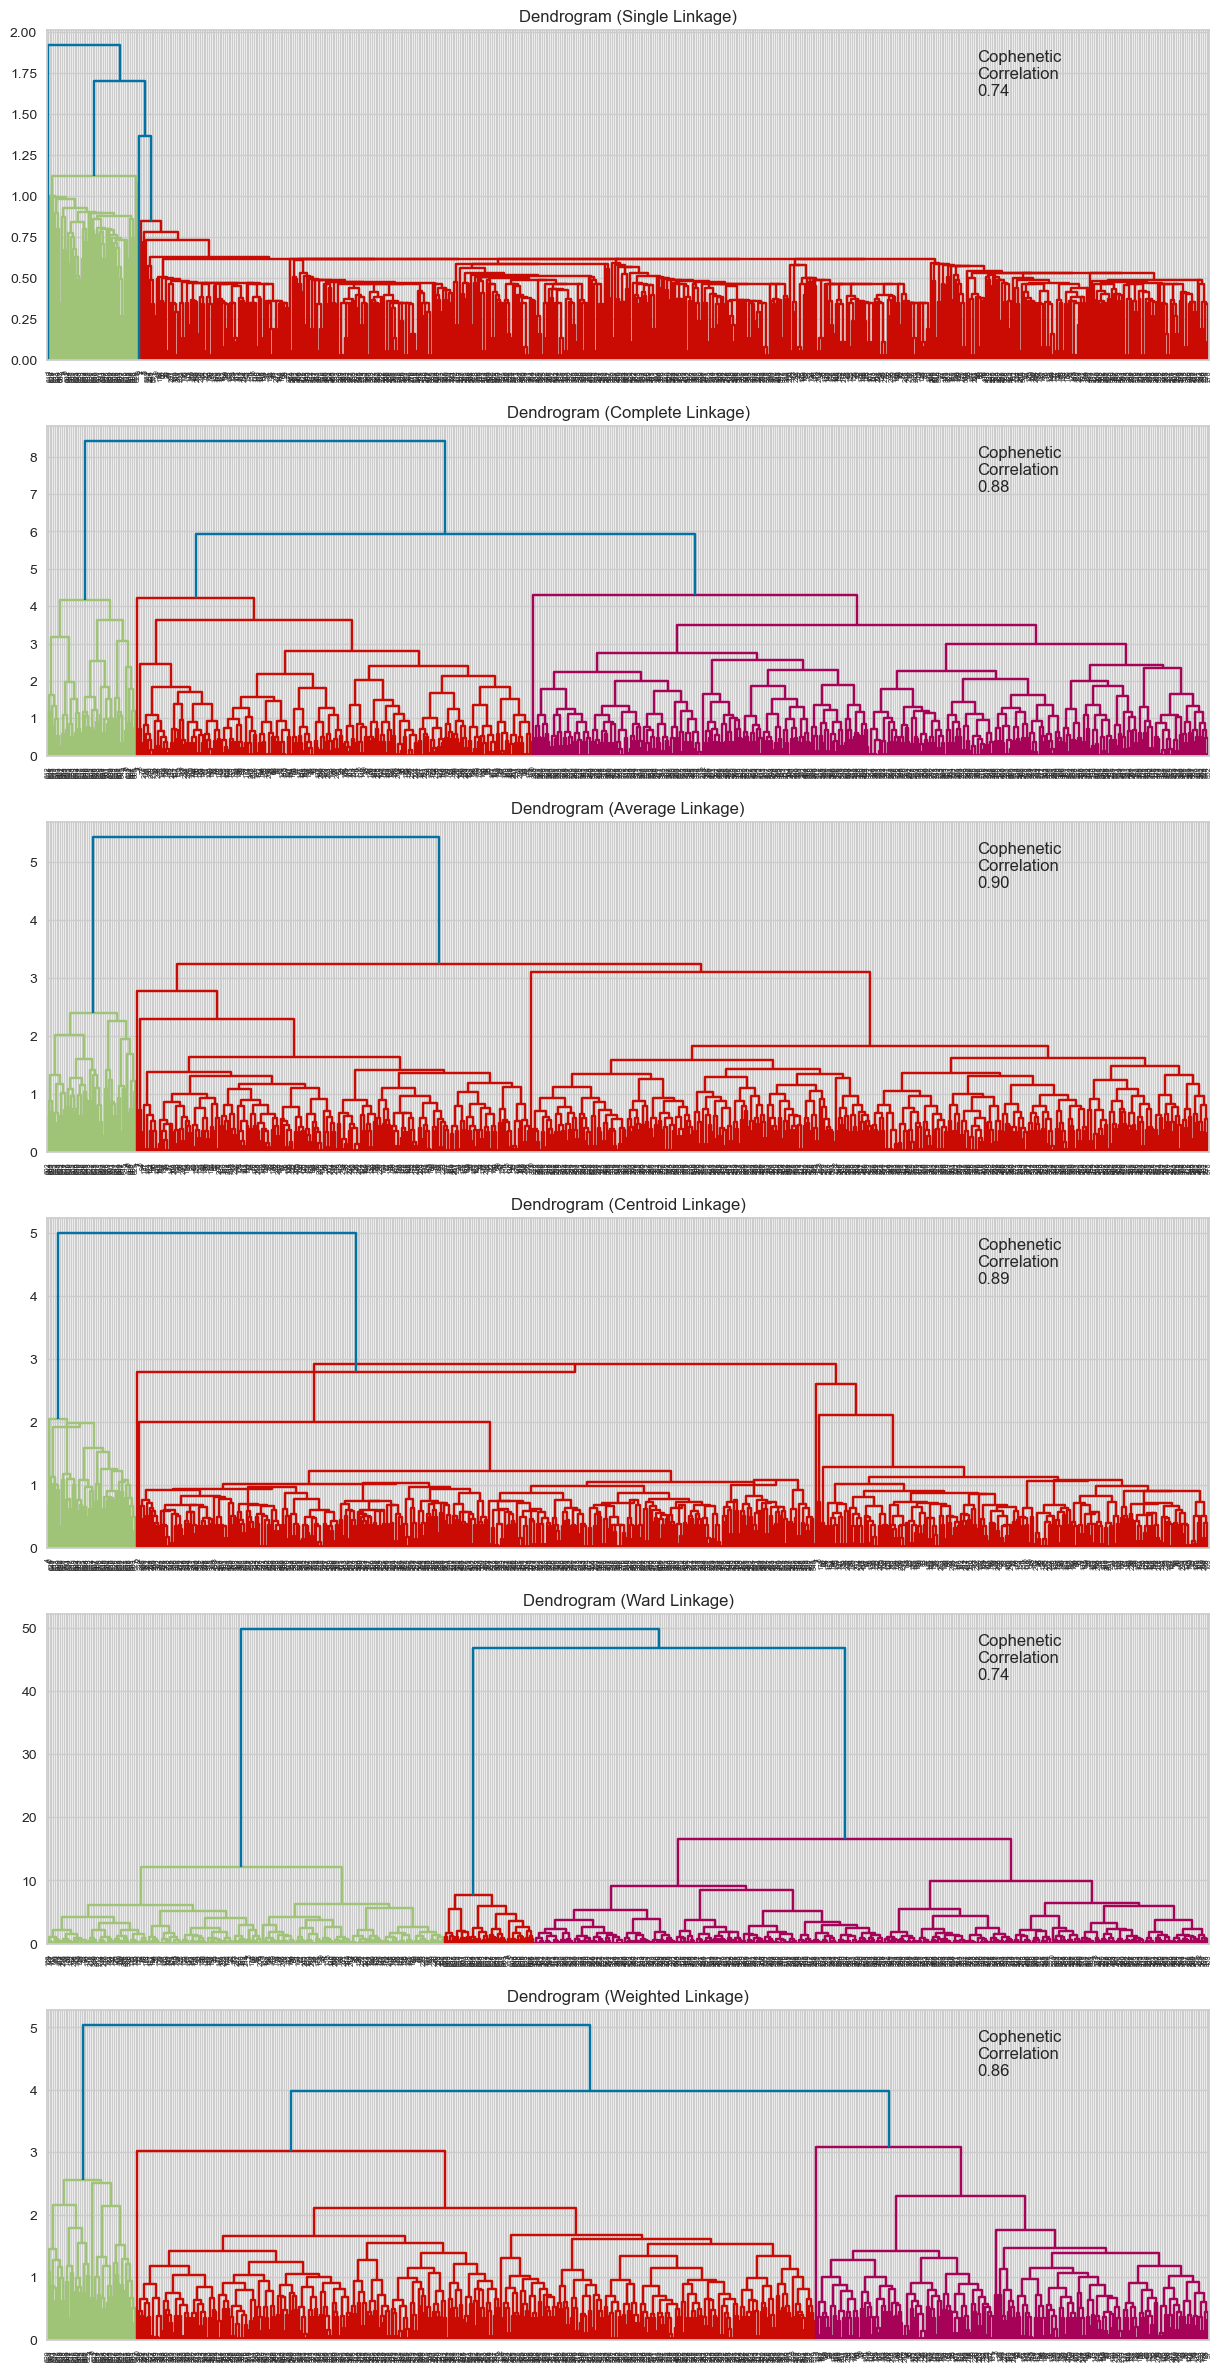

In [268]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

Observations:

 - The Cophentic correlation is highest for average linkage method, so we will move forward with this method.
 - About 7 clusters seem reasonable from the dendrogram of the average linkage.
 
 Recommendation about the data set and on using this technique:
 
 - The time taken to run the Hierarchical clustering algorithm was 38.2 seconds, compared to 0.6s for K-Means. Since this dataset consists of ~650 data points, this is OK. However, in the future, the size of the bank's dataset is bound to increase if the bank institution grows. Then, perhaps, it would not be feasible to run this technique.

In [269]:
HCmodel = AgglomerativeClustering(n_clusters=7, affinity="euclidean", linkage="average")
HCmodel.fit(df_scaled)

AgglomerativeClustering(linkage='average', n_clusters=7)

In [270]:
df_HC = df.copy()
df_scaled_HC = df_scaled.copy()

df_scaled_HC['HC_clusters'], df_HC['HC_clusters'] = HCmodel.labels_, HCmodel.labels_

#### Cluster Profiling - HC

In [271]:
cluster_profile_HC = df_HC.groupby('HC_clusters').mean()

In [272]:
cluster_profile_HC["count_in_each_segment"] = (
    df_HC.groupby("HC_clusters")['Avg_Credit_Limit'].count().values
)

In [273]:
# lets display cluster profile
cluster_profile_HC.style.highlight_max(color="green", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_clusters,,,,,,
0,138388.888889,8.555556,0.444444,14.000000,1.055556,18
1,12110.599078,2.400922,0.953917,3.557604,6.944700,217
2,142531.250000,8.843750,0.687500,9.156250,1.093750,32
3,100000.000000,2.000000,1.000000,1.000000,0.000000,1
4,50000.000000,3.000000,0.000000,10.000000,9.000000,1
5,33825.396825,5.523810,3.486772,0.984127,2.002646,378
6,10000.000000,2.500000,0.000000,1.500000,1.500000,2


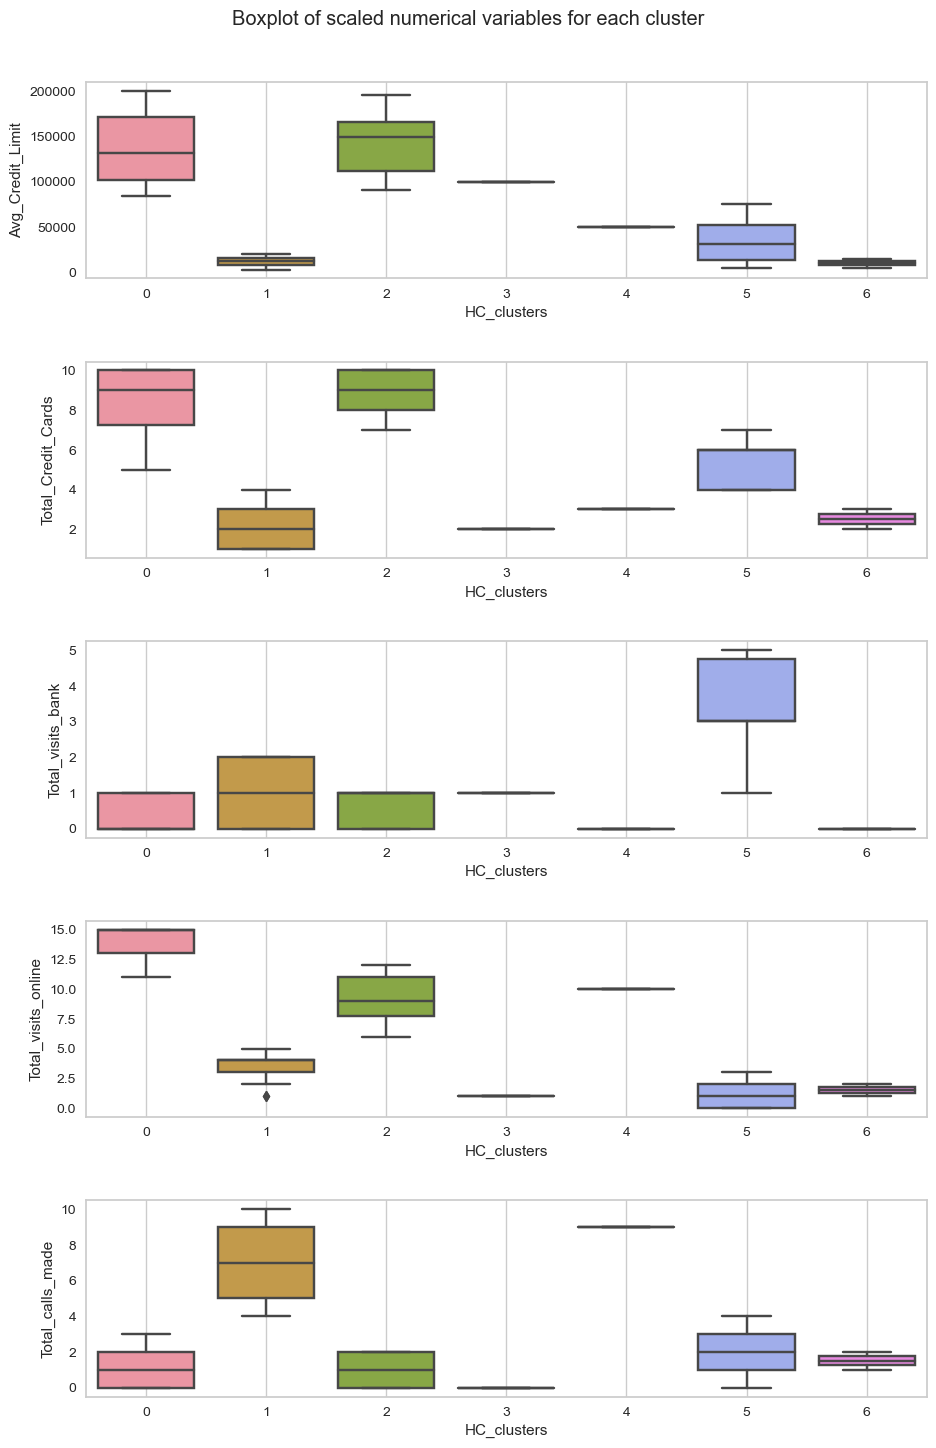

In [274]:
# plot each column/variable across each cluster to see the diversity
fig, axes = plt.subplots(5, figsize=(10, 15))
num_cols = list(df_HC.columns)
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for i in range(5):
    sns.boxplot(
        ax=axes[i],
        y=df_HC[num_cols[i]],
        x=df_HC["HC_clusters"],
    );
    axes[i].grid();

fig.tight_layout(pad=2.5);


#### Insights for HC | Clusters = 7

We will discuss Clusters 0,1,2, and 6 since the others have only 1 or 2 customers.

<b> Cluster 0: </b>
- There are 222 customers in this cluster, second highest in proportion
- Customers here have the lowest average credit limit, with a low amount of total credit cards
- This cluster' customers have made the second most amount of calls to the bank, with a 'normal' amount of online and in person visits
- Perhaps the customers had issues/queries because of which they made so many calls, or perhaps they wanted to make payments over the phone.

<b> Cluster 1: </b>
- There are 16 customers in this cluster
- Customers found here have the highest credit limit AND amount of credit cards, as well as the highest number of online visits
- In person visits and calls made are low.
- The reasons behind so many online visits can be plenty for this group, perhaps for frequent online payments, checking their balance (which might tend to be high because of higher financial service usage), etc.

<b> Cluster 2: </b>
- There are 32 customers in this cluster
- Similar to cluster 1, these customers have a high credit limit and amount of credit cards, but a lower amount of online visits than cluster 1, similar to clusters 4 amd 5.

<b> Cluster 6: </b>
- This has the highest proportion of customers, the total number being 386.
- Customers belonging here have the highest number of in person visits to the bank.
- This cluster's customers' average credit limit is about the same as the entire data set's average, but a higher-than-group-average number of credit cards.
- Low amounts of online visits and total calls made.


##### Recommendations

- Clusters 1 and 2 are important customer profiles to target new customers for the bank, since they have the highest usage of the bank's financial services, AND they are low maintenance customers in terms of communication; they make a low number of calls and in person visits, albeit high online visits.

Note: No need to implement dimensionality reduction since there are only 5 columns and >600 data points.

### Comparison between Hierarchical (HC) and K-Means (KM) Clustering

- K-Means produced 3 clusters, whereas we chose 7 clusters from Agglomerative Clustering. 
- HC clusters 1 and 2 are captured in KM cluster 2
- HC cluster 0 is very similar to KM cluster 0
- HC cluster 6 is very similar (if not the same) to KM cluster 1.

Overall, K-Means clustering captures the major clusters in a simple yet effective manner, and was much faster and less memory intensive to compute.

## Final Recommendations

To reiterate:
- To target new customers, the bank should concentrate their marketing efforts toward customers from cluster 2 (KM) or clusters 1,2 (HC) since they have high usage of the bank's financial services AND they are low maintenance customers in terms of communication; they make a low number of calls and in person visits, albeit high online visits. 
- A majority of the customers visit and call the bank at least once, so a recommendation would be for the bank to further improve its services in calling and in person visits so that customers are satisfied. Specifically, clusters 0,6 (HC) or clusters 0,1 (KM) hold a vast majority of customers that although are lower volume customers but have made a lot of calls and visits to the bank. This may well be reflected in a statement made in the Context of this project, which says that an "insight from the market research was that the customers perceive the support services of the back poorly." If backend support services can be improved, this may yield in converting these customers from low-volume to high-volume.


Data suggestions:
- Perhaps it would be more useful for the Data Scientists to have data about outcomes of all the modes of communication, as well as reason for communication. This would help in better analyzing and providing recommendations for the bank's issue-resolving services, as well as the customer satisfaction rate.